In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc
from pyro import poutine
pyro.enable_validation()

from pyro_webppl import flip, pflip, repeat, memoize, factor, cond_var, condition, expectation, Infer, viz

# Cognition and conditioning

We have built up a tool set for constructing probabilistic generative models. These can represent knowledge about causal processes in the world: running one of these programs generates a particular outcome by sampling a "history" for that outcome. However, the power of a causal model lies in the flexible ways it can be used to reason about the world. In the
last chapter we ran generative models *forward* to reason about outcomes from initial conditions. Generative models also enable reasoning in other ways.
For instance, if we have a generative model in which X is the output of a process that depends on Y (say `X = coolFunction(Y)`) we may ask: "assuming I have observed a certain X, what must Y have been?" That is we can reason *backward* from outcomes to initial conditions.
More generally, we can make hypothetical assumptions and reason about the generative history: "assuming *something*, how did
the generative model run?"
In this section we describe how a wide variety of such hypothetical inferences can be made from a single generative model by *conditioning* the model on an assumed or observed fact.

Much of cognition can be understood in terms of conditional inference.  In its most basic form, *causal attribution* is conditional inference: given some observed effects, what were the likely causes?  *Predictions* are conditional inferences in the opposite direction: given that I have observed some cause, what are its likely effects?  These inferences can be described by conditioning a probabilistic program that expresses a causal model.  The acquisition of that causal model, or *learning*, is also conditional inference at a higher level of abstraction: given our general knowledge of how causal relations operate in the world, and some observed events in which candidate causes and effects co-occur in various ways, what specific causal relations are likely to hold between these observed variables?

To see how the same concepts apply in a domain that is not usually thought of as causal, consider language.  The core questions of interest in the study of natural language are all at heart conditional inference problems.  Given beliefs about the  structure of my language, and an observed sentence, what should I believe about the syntactic structure of that sentence? This is the *parsing* problem. The complementary problem of *speech production* is related: given the structure of my language (and beliefs about others' beliefs about that), and a particular thought I want to express, how should I encode the thought? Finally, the *acquisition* problem: given some data from a particular language, and perhaps general knowledge about universals of grammar, what should we believe about that language's structure? This problem is simultaneously the problem facing the linguist and the child trying to learn a language.

Parallel problems of conditional inference arise in visual perception, social cognition, and virtually every other domain of cognition.  In visual perception, we observe an image or image sequence that is the result of rendering a three-dimensional physical scene onto our two-dimensional retinas.  A probabilistic program can model both the physical processes at work in the world that produce natural scenes, and the imaging processes (the "graphics") that generate images from scenes.  *Perception* can then be seen as conditioning this program on some observed output image and inferring the scenes most likely to have given rise to it. 

When interacting with other people, we observe their actions, which result from a planning process, and often want to guess their desires, beliefs, emotions, or future actions. Planning can be modeled as a program that takes as input an agent's mental states (beliefs, desires, etc.) and produces action sequences---for a rational agent, these will be actions that are likely to produce the agent's desired states reliably and efficiently.  A rational agent can *plan* their actions by conditional inference to infer what steps would be most likely to achieve their desired state.  *Action understanding*, or interpreting an agent's observed behavior, can be expressed as conditioning a planning program (a "theory of mind") on observed actions to infer the mental states that most likely gave rise to those actions, and to predict how the agent is likely to act in the future.


# Hypothetical Reasoning with `Infer`

Suppose that we know some fixed fact, and we wish to consider hypotheses about how a generative model could have given rise to that fact. In the last chapter, we met the `Infer` operator for constructing the marginal distribution on return values of a function; with the help of the `condition` operator `Infer` is also able to describe marginal distributions *under some assumption* or condition.

Consider the following simple generative model:


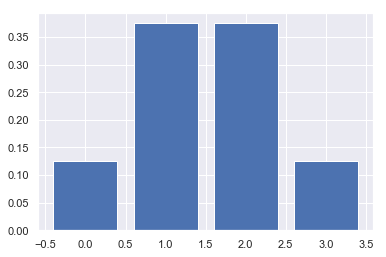

In [2]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    return A + B + C

# make the marginal distributions on return values explicit
d = Infer(model, posterior_method='enumerate')
viz(d)

The process described in `model` samples three numbers and adds them (Python converts $\texttt{True} \rightarrow 1$ and $\texttt{False} \rightarrow 0$ when they enter arithmetic). The value of the final expression here is 0, 1, 2 or 3. A priori, each of the variables `A`, `B`, `C` has .5 probability of being `1` or `0`.  However, suppose that we know that the sum `D` is equal to 3. How does this change the space of possible values that variable `A` could have taken?  `A` (and `B` and `C`) must be equal to 1 for this result to happen. We can see this in the following PyroWebPPL inference, where we use `condition` to express the desired assumption:


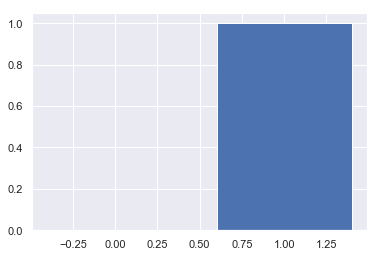

In [3]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    condition('D', bool(A + B + C == 3))
    return A

d = Infer(model, posterior_method='enumerate')
viz(d)


The output of `Infer` describes appropriate beliefs about the likely value of `A`, conditioned on `D` being equal to 3.

Now suppose that we condition on `D` being greater than or equal to 2.  Then `A` need not be 1, but it is more likely than not to be. (Why?) The corresponding plot shows the appropriate distribution of beliefs for `A` conditioned on this new fact:


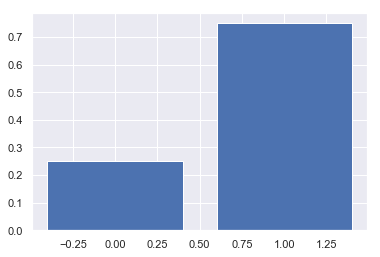

In [4]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    condition('D', bool(A + B + C >= 2))
    return A

d = Infer(model, posterior_method='enumerate')
viz(d)

Going beyond the basic intuition of "hypothetical reasoning", the `Infer` operation in the presence of `condition` can be understood in several, equivalent, ways. We focus on two: the process of *rejection sampling*, and the the mathematical formulation of a *conditional distribution*.

# Rejection Sampling

How can we imagine answering a hypothetical such as those above? We have already seen how to get a sample from a generative model, without constraint, by simply running the evaluation process "forward"  (i.e. simulating the process). We can get conditional samples by forward sampling the entire model, but only keeping the sample if the value passed to `condition` is *true*. For instance, to sample from the above model "A given that D is greater than 2" we could:

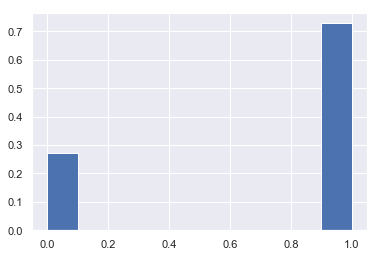

In [5]:
def conditioned_model_sample():
    A = flip(0.5)
    B = flip(0.5)
    C = flip(0.5)
    D = A + B + C
    if D >= 2:
        return A
    return conditioned_model_sample()

viz(repeat(conditioned_model_sample, 1000))

Notice that we have used a stochastic recursion to sample the model repeatedly until `D >= 2` is `true`, and we then return `A`: we generate and test until the condition is satisfied.
This process is known as *rejection sampling*; we can use this technique to make a more general function that implements `Infer`, which we access in PyroWebPPL with the `'rejection'` method:


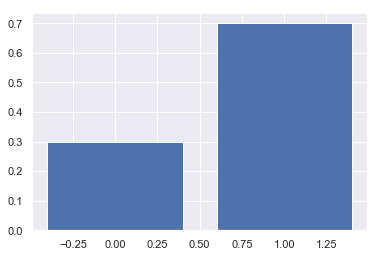

In [6]:
d = Infer(model, posterior_method='rejection', num_samples=100)
viz(d)

## Conditional Distributions

The formal definition of *conditional probability* in probability theory is

$$ P(A=a \mid B=b)=\frac{ P(A=a,B=b)}{P(B=b)} $$

Here $P(A=a \mid B=b)$ is the probability that "event" $A$ has value $a$ given that $B$ has value $b$. (The meaning of events $A$ and $B$ must be given elsewhere in this notation, unlike a PyroWebPPL program, which contains the full model specification within the `Infer` call.)
The *joint probability*, $P(A=a,B=b)$,  is the probability that $A$ has value $a$ and $B$ has value $b$.
So the conditional probability is simply the ratio of the joint probability to the probability of the condition.

In the case of a PyroWebPPL `Infer` statement with a `condition`, $A=a$ will be the "event" that the return value is $a$, while $B=b$ will be the event that the value passed to condition is `true` (so $b$ is *True*). Because each of these is a regular (unconditional) probability, they and their ratio can often be computed exactly using the rules of probability. In PyroWebPPL the inference method `'enumerate'` attempts to do this calculation (by first enumerating all the possible executions of the model):

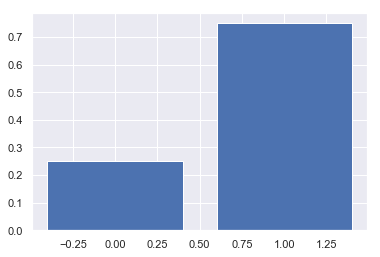

In [7]:
d = Infer(model, posterior_method='enumerate', num_samples=1000)
viz(d)

### Connection to rejection sampling

The above notion of conditional distribution in terms of rejection sampling is equivalent to the mathematical definition, when both are well-defined. (There are special cases when only one definition makes sense. For instance, when continuous random choices are used it is possible to find situations where rejection sampling almost never returns a sample but the conditional distribution is still well defined. Why?)

Indeed, we can use the process of rejection sampling to understand this alternative definition of the conditional probability $P(A=a \mid B=b)$. 
Imagine that we have sampled $N_{total}$ times.
We only keep those samples in which the condition is true, say there are $N_{B=True}$ of them.
Of these some number $N_{A=a, B=True}$ have the returned value $a$.
The ratio 

$$\frac{N_{A=a, B=True}}{N_{B=True}} = \frac{\frac{N_{A=a, B=True}}{N_{total}}}{\frac{N_{B=True}}{N_{total}}}$$

is the fraction of times that $A=a$ when $B=True$. When the number of samples is very large this converges to $\frac{P(A=a, B=True)}{P(B=True)}$. Thus the rejection sampling definition of conditional probability implies the above (probability ratio) definition.


<!-- FIXME: add a figure with imagined samples to illustrate. -->

Try using the formula for conditional probability to compute the probability of the different return values in the above examples. Check that you get the same probability that you observe when using rejection sampling.

### Bayes Rule

One of the most famous rules of probability is *Bayes' rule*, which states:

$$P(h \mid d) = \frac{P(d \mid h)P(h)}{P(d)}$$

It is first worth noting that this follows immediately from the definition of conditional probability:

$$P(h \mid d) = \frac{P(d,h)}{P(d)} = \frac{ P(d, h)P(h) }{ P(d)P(h)} = \frac{P(d \mid h)P(h)}{P(d)}$$

Next we can ask what this rule means in terms of sampling processes. Consider the program:

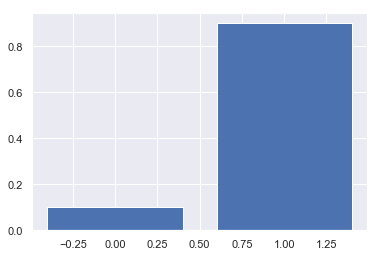

In [8]:
observed_data = True
prior = lambda: pflip('prior', 0.5)
likelihood = lambda h: pflip('h', (0.9 if h else 0.1))

def model():
    hypothesis = prior()
    data = likelihood(hypothesis)
    condition('cond', data, observed_data)
    return hypothesis

posterior = Infer(model)
viz(posterior)

We have generated a value, the *hypothesis*, from some distribution called the *prior*, then used an observation function `likelihood` which generates data given this hypothesis, the probability of such an observation function is usually called the *likelihood*. Finally we have returned the hypothesis, conditioned on the observation being equal to some observed data---this conditional distribution is called the *posterior*. This is a typical setup in which Bayes' rule is used.

Bayes' rule simply says that, in special situations where the model decomposes nicely into a part "before" the value to be returned (hypothesis) and a part "after" the value to be returned, then the conditional probability can be expressed simply in terms of the prior and likelihood components of the model. This is often a useful way to think about conditional inference in simple settings. However, we will see examples as we go along where Bayes' rule doesn't apply in a simple way, but the conditional distribution is equally well understood in other terms.

## Other implementations of `Infer`

Much of the difficulty of implementing the PyroWebPPL language (or probabilistic models in general) is in finding useful ways to do conditional inference---to implement `Infer`.
We have already seen rejection sampling and enumeration, but the AI literature is replete with other algorithms and techniques for dealing with conditional probabilistic inference.
Many of these have been adapted into PyroWebPPL to give implementations of `Infer` that may be more efficient in various cases.
Switching from one method to another is as simple as changing the options passed to `Infer`. We have already seen two methods: `{method: 'enumerate'}` and `{method: 'rejection', samples: X}`; other methods include `'MCMC'`, `'SMC'`, and `'variational'`.
Sometimes we even drop the method argument, asking PyroWebPPL to guess the best inference method (which is can often do).
The [Infer documentation](http://docs.webppl.org/en/master/inference/index.html) provides many more usage details.

There is an interesting parallel between the `Infer` abstraction, wrapping up the engineering challenge of different inference methods, and the idea of levels of analysis in cognitive science @Marr1982. At the top, or computational level, of analysis we are concerned more with the world knowledge people have and the inferences they license; at the next, algorithmic, level of analysis we are concerned with the details on *how* these inferences are done.
In parallel, PyroWebPPL allows us to specify generative knowledge and inference questions, largely abstracting away the methods of inference (they show up only in the options argument to `Infer`, when provided).
We will further explore some of the algorithms used in these implementations in [Algorithms for inference](inference-algorithms.html), and ask whether they may be useful algorithmic levels models for human thinking in [Rational process models](process-models.html). For most of this book, however, we work at the computational level, abstracting away from algorithmic details.

<!--TODO: add more on the levels of analysis analogy. perhaps in the process models section?-->

# Conditions and observations

A very common pattern is to condition directly on the value of a sample from some distribution. For instance here we try to recover a true number from a noisy observation of it:

In [ ]:
def conditioned_model():
    true_x = dist.Normal(0, 1).sample()
    obs_x = pyro.sample('obs_x', dist.Normal(true_x, 0.1))
    condition('eq', bool(obs_x==torch.tensor(0.2)))
    return true_x

# This will keep running until you interrupt the notebook kernel
viz(Infer(conditioned_model, posterior_method='rejection', draw_samples=True))


You will note that this never finishes. (Why? Think about what rejection sampling tries to do here....)
In PyroWebPPL we have a special operator, `observe`, to express the pattern of conditioning on a value sampled directly from a distribution. In addition to being clearer, it also gives the implementation some hints about how to do inference.


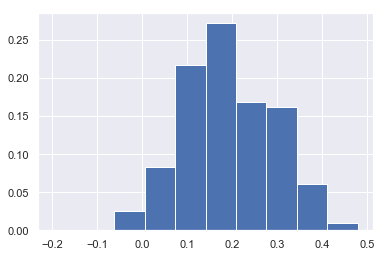

In [13]:
# Variant 1: forward inference
viz(Infer(conditioned_model, posterior_method='forward', draw_samples=True))

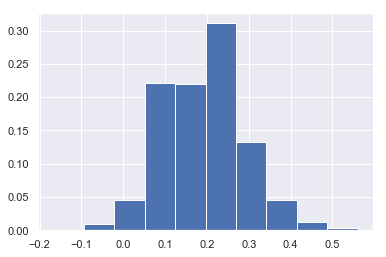

In [14]:
# Variant 2: observe the value
def conditioned_model():
    true_x = dist.Normal(0, 1).sample()
    obs_x = pyro.sample('obs_x', dist.Normal(true_x, 0.1), obs=torch.tensor(0.2))
    return true_x

viz(Infer(conditioned_model, posterior_method='rejection', draw_samples=True))


It is natural and common to condition a generative model on a value for one of the variables declared in this model (i.e. to `observe` its value). However, there are many situations in which we desire the greater expressivity of `condition`; one may wish to ask for more complex hypotheticals: "what if P," where P is a complex proposition composed out of variables declared in the model.
Consider the following PyroWebPPL inference:

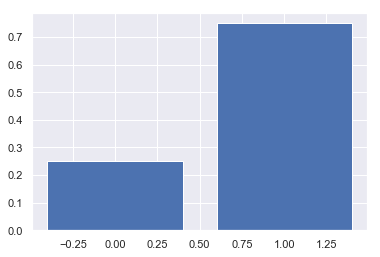

In [10]:
def model():
    A = pflip('A', 0.5)
    B = pflip('B', 0.5)
    C = pflip('C', 0.5)
    D = int(A + B + C >= 2)
    pyro.sample('D', dist.Normal(D, 1e-15))
    return A

conditioned_model = pyro.condition(model, data={'D': torch.tensor(2)})

d = Infer(conditioned_model, posterior_method='enumerate')
viz(d)

This inference has the same meaning as the earlier example, but the formulation is importantly different. We have directly conditioned on the complex assumption that the sum of these random variables is greater than or equal to 2. This involves a new value or "random variable", `A + B + C >= 2` that *did not appear* anywhere in the generative model (the var definitions).
We could have instead added a definition `var D = (A + B + C >= 2)` to the generative model and conditioned (or observed) its value.
However this intertwines the hypothetical assumption (condition) with the generative model knowledge (definitions), and this is not what we want: we want a simple model which supports many queries, rather than a complex model in which only a prescribed set of queries is allowed.
Using `condition` allows the flexibility to build complex random expressions like this as needed, making assumptions that are phrased as complex propositions, rather than simple observations.  Hence the effective number of queries we can construct for most programs will not merely be a large number but countably infinite, much like the sentences in a natural language.  The `Infer` function (in principle, though with variable efficiency) supports correct conditional inference for this infinite array of situations.

# Factors

In PyroWebPPL, `condition` and `observe` are actually special cases of a more general operator: `factor`. Whereas `condition` is like making an assumption that must be true, then `factor` is like making a *soft* assumption that is merely preferred to be true. For instance, suppose we flip a single coin. If we condition on the outcome being heads, then the outcome must be heads: 

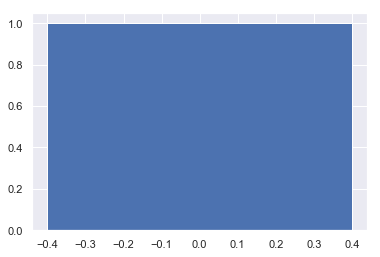

In [11]:
def model():
    A = flip()
    factor('B', (0 if A else -99999))
    return A

d = Infer(model, num_samples=int(1e4))
viz(d)

However, if we swap `condition` for `factor`, we simply make heads more likely:


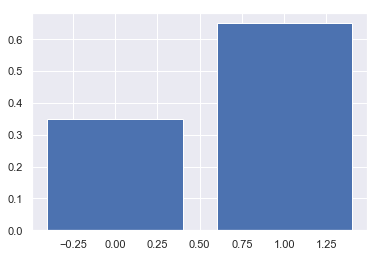

In [12]:
def model():
    A = pflip('A', 0.5)
    factor('B', (0 if A else -1))
    return A

d = Infer(model, num_samples=int(1e4))
viz(d)

Technically, `factor(x)` adds `x` to the unnormalized log-probability of the program execution within which it occurs. Thus, to get the new probabilities induced by the `factor` statement we compute the normalizing constant given these log-scores. The resulting probability $P(A=true)$ is:

$P(A=true) = \frac {e^{1}} { (e^{0} + e^{1}) }$

Play with this example. Can you revise the example to increase the probability of heads? 

The `factor` construct is very general. Both `condition` and `observe` can be written easily in terms of `factor`. However models are often clearer when written with the more specialized forms. In machine learning it is common to talk of *directed* and *undirected* generative models; directed models can be thought of as those made from only `sample` and `observe`, while undirected models include `factor` (and often have only factors).

# Example: Reasoning about Tug of War

Imagine a game of tug of war, where each person may be strong or weak, and may be lazy or not on each match.
If a person is lazy they only pull with half their strength.
The team that pulls hardest will win.
We assume that strength is a continuous property of an individual, and that on any match, each person has a 1 in 3 chance of being lazy.
This PyroWebPPL program runs a tournament between several teams, mixing up players across teams.
Can you guess who is strong or weak, looking at the tournament results?

In [13]:
@memoize
def strength(person):
    return abs(dist.Normal(1, 1).sample())

def lazy(person):
    return flip(1 / 3.)

def pulling(person):
    return (strength(person) / 2 if lazy(person) else strength(person))

def total_pulling(team):
    return sum(map(pulling, team))

def winner(team1, team2):
    return team1 if (total_pulling(team1) > total_pulling(team2)) else team2

[
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'bob'], ['sue', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'sue'], ['bob', 'tom']),
    winner(['alice', 'tom'], ['bob', 'sue']),
    winner(['alice', 'tom'], ['bob', 'sue'])
]

[['alice', 'bob'],
 ['alice', 'bob'],
 ['alice', 'sue'],
 ['alice', 'sue'],
 ['alice', 'tom'],
 ['alice', 'tom']]


Notice that `strength` is memoized because this is a property of a person true across many matches, while `lazy` isn't.
Each time you run this program, however, a new "random world" will be created: people's strengths will be randomly re-generated, then used in all the matches.

We can use `Infer` to ask a variety of different questions. For instance, how likely is it that Bob is strong, given that he's been on a series of winning teams? (Note that we have added the helper function `beat` as in "team1 beat team2"; this just makes for more compact conditioning statements.)




Expected strength: <built-in method mean of Tensor object at 0x13384a9d8>


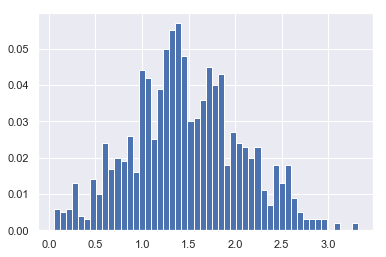

In [14]:
def model():
    
    @memoize
    def strength(person):
        return pyro.sample(f'strength_{person}', dist.Normal(1, 1)).abs()

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return winner(team1, team2) == team1

    condition('beats_1', beat(['bob', 'mary'], ['tom', 'sue']))
    condition('beats_2', beat(['bob', 'sue'],  ['tom', 'jim']))
    return strength('bob')

d = Infer(model, posterior_method='rejection', num_samples=1000, draw_samples=True)

print('Expected strength: {}'.format(d.mean))
viz(d, plot_args={'bins': 50})


Try varying the number of different teams and teammates that Bob plays with. How does this change the estimate of Bob's strength?
Do these changes agree with your intuitions? Can you modify this example to make laziness a continuous quantity? Can you add a person-specific tendency toward laziness?

A model very similar to this was used in @Gerstenberg2012 to predict human judgements about the strength of players in ping-pong tournaments. It achieved very accurate quantitative predictions without many free parameters.

<!--TODO: add actual conditions from expt. add actual data here and/or in bda chapter.-->

We can form many complex queries from this simple model. We could ask how likely a team of Bob and Mary is to beat a team of Jim and Sue, given that Mary is at least as strong as sue, and Bob beat Jim in a previous direct match up:



Expectation of first team winning: 0.9160000085830688


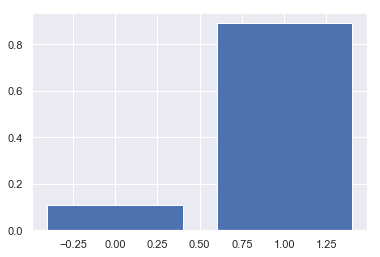

In [15]:
def model():

    @memoize
    def strength(person):
        return pyro.sample(f'strength_{person}', dist.Normal(1, 1)).abs()

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return torch.tensor(winner(team1, team2) == team1, dtype=torch.float)

    condition('stronger', bool(strength('mary') >= strength('sue')))
    condition('beats', beat(['bob'], ['jim']))
    return beat(['bob', 'mary'], ['jim', 'sue'])


# d = Infer(model, posterior_method='rejection', marginal_method='hash', num_samples=1000)
d = Infer(model, posterior_method='rejection', num_samples=1000)

support = list(d.enumerate_support())  #.tolist()
m = sum(support) / len(support)

print('Expectation of first team winning: {}'.format(m))
viz(d)

hidden: doing these jointly in a single model with pyro.condition. there must be a better way to do this.

<!--
def model():
    
    @memoize
    def strength(person):
        return pyro.sample(f'strength_{person}', dist.Normal(1, 1)).abs()

    def lazy(person): 
        return flip(1 / 3.)
    
    def pulling(person): 
        return strength(person) / 2 if lazy(person) else strength(person)
    
    def total_pulling(team): 
        return sum(map(pulling, team))
    
    def winner(team1, team2): 
        return team1 if (total_pulling(team1) > total_pulling(team2)) else team2 
    
    def beat(team1, team2): 
        return torch.tensor(winner(team1, team2) == team1, dtype=torch.float)  #winner(team1, team2) == team1

    cond_var('beats_1', beat(['bob', 'mary'], ['tom', 'sue']))
    cond_var('beats_2', beat(['bob', 'sue'],  ['tom', 'jim']))
    cond_var('stronger', torch.tensor(strength('mary') >= strength('sue'), dtype=torch.float))
    cond_var('beats', beat(['bob'], ['jim']))
    
    return strength('bob'), beat(['bob', 'mary'], ['jim', 'sue'])


conditioned_model = pyro.condition(lambda: model()[0], 
                                   data={'beats_1': torch.tensor(1), 
                                         'beats_2': torch.tensor(1)})
d = Infer(conditioned_model, posterior_method='rejection', num_samples=1000)
print('Expected strength: {}'.format(d.mean))
viz(d, plot_args={'bins': 30})


conditioned_model = pyro.condition(lambda: model()[1], 
                                   data={'stronger': torch.tensor(1), 
                                         'beats': torch.tensor(1)})
d = Infer(conditioned_model, posterior_method='rejection', num_samples=1000)
viz(d, plot_args={'bins': 30})

-->

# Example: Causal Inference in Medical Diagnosis


This classic Bayesian inference task is a special case of conditioning. Kahneman and Tversky, and Gigerenzer and colleagues, have studied how people make simple judgments like the following:

> The probability of breast cancer is 1% for a woman at 40 who participates in a routine screening. If a woman has breast cancer, the probability is 80% that she will have a positive mammography. If a woman does not have breast cancer, the probability is 9.6% that she will also have a positive mammography. A woman in this age group had a positive mammography in a routine screening. What is the probability that she actually has breast cancer?

What is your intuition? Many people without training in statistical inference judge the probability to be rather high, typically between 0.7 and 0.9. The correct answer is much lower, less than 0.1, as we can see by running this PyroWebPPL inference:

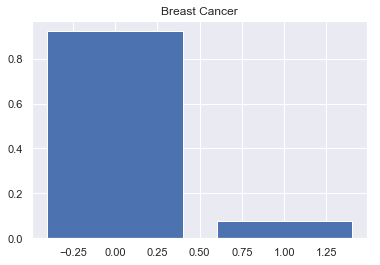

In [16]:
def model():
    breast_cancer = pflip('breast_cancer', 0.01)
    pm_prob = 0.8 if breast_cancer else 0.096
    positive_mammogram = pflip('positive_mammogram', pm_prob)
    condition('p', positive_mammogram)
    return breast_cancer
   
d = Infer(model, posterior_method='enumerate', num_samples=1000)
viz(d, title='Breast Cancer')


@Tversky1974 named this kind of judgment error *base rate neglect*, because in order to make the correct judgment, one must realize that the key contrast is between the *base rate* of the disease, 0.01 in this case, and the *false alarm rate* or probability of a positive mammogram given no breast cancer, 0.096.  The false alarm rate (or *FAR* for short) seems low compared to the probability of a positive mammogram given breast cancer (the *likelihood*), but what matters is that it is almost ten times higher than the base rate of the disease.  All three of these quantities are needed to compute the probability of having breast cancer given a positive mammogram using Bayes' rule for posterior conditional probability:

$$P(\text{cancer} \mid \text{positive mammogram}) = \frac{P(\text{positive mammogram} \mid \text{cancer} ) \times P(\text{cancer})}{P(\text{ positive mammogram})}$$

$$= \frac{0.8 \times 0.01}{0.8 \times 0.01 + 0.096 \times 0.99} = 0.078$$

@Gigerenzer1995 showed that this kind of judgment can be made much more intuitive to untrained reasoners if the relevant probabilities are presented as "natural frequencies", or the sizes of subsets of relevant possible outcomes:

> On average, ten out of every 1000 women at age 40 who come in for a routine screen have breast cancer.  Eight out of those ten women will get a positive mammography.  Of the 990 women without breast cancer, 95 will also get a positive mammography. We assembled a sample of 1000 women at age 40 who participated in a routine screening.  How many of those who got a positive mammography do you expect to actually have breast cancer?

Now one can practically read off the answer from the problem formulation: 8 out of 103 (95+8) women in this situation will have breast cancer.

Gigerenzer (along with Cosmides, Tooby and other colleagues) has argued that this formulation is easier because of evolutionary and computational considerations: human minds have evolved to count and compare natural frequencies of discrete events in the world, not to add, multiply and divide decimal probabilities.  But this argument alone cannot account for the very broad human capacity for causal reasoning.  We routinely make inferences for which we haven't stored up sufficient frequencies of events observed *in the world.* (And often for which no one has told us the relevant frequencies, although perhaps we have been told about degrees of causal strength or base rates in the form of probabilities or other linguistic encoding).

However, the basic idea that the mind is good at manipulating frequencies of situations, but bad at arithmetic on continuous probability values, can be extended to cope with novel situations if the frequencies that are manipulated can be frequencies of *imagined* situations. Recall that probabilistic programs explicitly give instructions for sampling imagined situations, and only implicitly specify probability distributions. If human inference is similar to a PyroWebPPL inference then it would readily create and manipulate imagined situations, and this could explain both why the frequency framing of Bayesian probability judgment is natural to people and how people cope with rarer and more novel situations.  The numbers given in the frequency formulation (or close approximations thereof) can be read off a tree of evaluation histories for 1000 calls of the PyroWebPPL program that specifies the causal model for this problem:

TODO: image <br>
TODO: image <br>
TODO: image <br>
TODO: image <br>
TODO: image <br>
TODO: image <br>

Each path from root to leaf of this tree represents a sequence of random choices made in evaluating the above program (the first flip for breast-cancer, the second for positive-mammogram), with the number of traversals and the sampled value labeling each edge. (Because this is 1000 *random* samples, the number are close (but not exactly) those in the Gigerenzer, et al, story.) Selecting just the 106 hypothetical cases of women with a positive mammogram, and computing the fraction of those who also have breast cancer (7/106), corresponds exactly to `Infer({method: 'rejection'})`. Thus, we have used the causal representation in the above program to manufacture frequencies which can be used to arrive at the inference that relatively few women with positive mammograms actually have breast cancer.

Yet unlike the rejection sampler people are quite bad at reasoning in this scenario. Why? One answer is that people don't represent their knowledge in quite the form of this simple program.
Indeed, @Krynski2007 have argued that human statistical judgment is fundamentally based on conditioning more explicit causal models:  they suggested that "base rate neglect" and other judgment errors may occur when people are given statistical information that cannot be easily mapped to the parameters of the causal models they intuitively adopt to describe the situation.  In the above example, they suggested that the notion of a false alarm rate is not intuitive to many people---particularly when the false alarm rate is ten times higher than the base rate of the disease that the test is intended to diagnose!  They showed that "base rate neglect" could be eliminated by reformulating the breast cancer problem in terms of more intuitive causal models.  For example, consider their version of the breast cancer problem (the exact numbers and wording differed slightly):

> 1% of women at age 40 who participate in a routine screening will have breast cancer.  Of those with breast cancer, 80% will receive a positive mammogram.  20% of women at age 40 who participate in a routine screening will have a benign cyst.  Of those with a benign cyst, 50% will receive a positive mammogram due to unusually dense tissue of the cyst.  All others will receive a negative mammogram.  Suppose that a woman in this age group has a positive mammography in a routine screening. What is the probability that she actually has breast cancer?

This question is easy for people to answer---empirically, just as easy as the frequency-based formulation given above.  We may conjecture this is because the relevant frequencies can be computed from a simple inference on the following more intuitive causal model:


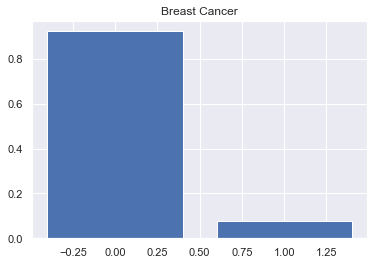

In [17]:
def model():
    breast_cancer = pflip('breast_cancer', 0.01)
    benign_cyst = pflip('benign_cyst', 0.2)
    pm_prob = ((breast_cancer and pflip('bc2', 0.8)) or 
               (benign_cyst and pflip('bc1', 0.5)))
    
    positive_mammogram = pflip('positive_mammogram', pm_prob)
    condition('p', positive_mammogram)
    return breast_cancer
   
d = Infer(model, posterior_method='enumerate', num_samples=1000)
viz(d, title='Breast Cancer')


Because this causal model---this PyroWebPPL program---is more intuitive to people, they can imagine the appropriate situations, despite having been given percentages rather than frequencies.
What makes this causal model more intuitive than the one above with an explicitly specified false alarm rate?  Essentially we have replaced probabilistic dependencies on the "non-occurrence" of events (e.g., the dependence of a positive mammogram on *not* having breast cancer) with dependencies on explicitly specified alternative causes for observed effects (e.g., the dependence of a positive mammogram on having a benign cyst).

A causal model framed in this way can scale up to significantly more complex situations.  Recall our more elaborate medical diagnosis network from the previous section, which was also framed in this way using noisy-logical functions to describe the dependence of symptoms on disease:


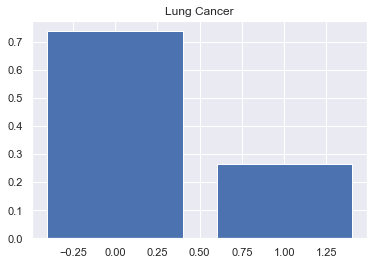

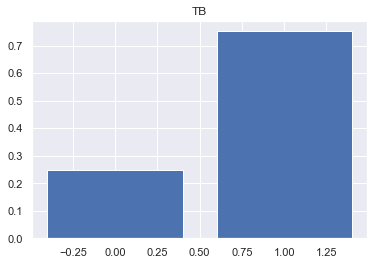

In [18]:
def model():
    lung_cancer = pflip('lung_cancer', 0.01)
    tb = pflip('tb', 0.005)
    cold = pflip('cold', 0.2)
    stomach_flu = pflip('stomach_flu', 0.1)
    other = pflip('other', 0.1)

    cough = ((cold and pflip('cold-cough', 0.5)) or
             (lung_cancer and pflip('lung_cancer-cough', 0.3)) or
             (tb and pflip('tb-cough', 0.7)) or
             (other and pflip('other-cough', 0.01)))

    fever = ((cold and pflip('cold-fever', 0.3)) or
             (stomach_flu and pflip('stomach_flu-fever', 0.5)) or
             (tb and pflip('tb-fever', 0.2)) or
             (other and pflip('other-fever', 0.01)))

    chest_pain = ((lung_cancer and pflip('lung_cancer-chest_pain', 0.4)) or
                  (tb and pflip('tb-chest_pain', 0.5)) or
                  (other and pflip('other-chest_pain', 0.01)))

    shortness_of_breath = ((lung_cancer and pflip('lung_cancer-breath', 0.4)) or
                           (tb and pflip('tb-breath', 0.5)) or
                           (other and pflip('other-breath', 0.01)))

    condition('symptoms', cough and fever and chest_pain and shortness_of_breath)
    return lung_cancer, tb

d_cancer = Infer(lambda: model()[0], posterior_method='enumerate', num_samples=3000)
d_tb = Infer(lambda: model()[1], posterior_method='enumerate', num_samples=3000)

viz(d_cancer, title='Lung Cancer')
viz(d_tb, title='TB')


You can use this model to infer conditional probabilities for any subset of diseases conditioned on any pattern of symptoms.  Try varying the symptoms in the conditioning set or the diseases in the inference, and see how the model's inferences compare with your intuitions.  For example, what happens to inferences about lung cancer and TB in the above model if you remove chest pain and shortness of breath as symptoms?  (Why?  Consider the alternative explanations.)  More generally, we can condition on any set of events -- any combination of symptoms and diseases -- and query any others.  We can also condition on the negation of an event (using the JavaScript negation operator `!`): how does the probability of lung cancer (versus TB) change if we observe that the patient does *not* have a fever (i.e. `condition(!fever)`), does *not* have a cough, or does not have either symptom?

As we discussed above, PyroWebPPL program thus effectively encodes the answers to a very large number of possible questions in a very compact form.  In the program above, there are $$3^9=19683$$ possible simple conditions corresponding to conjunctions of events or their negations (because the program has 9 stochastic Boolean-valued functions, each of which can be observed true, observed false, or not observed). Then for each of those conditions there are a roughly comparable number of queries, corresponding to all the possible conjunctions of variables that can be in the return value expression. This makes the total number of simple questions encoded on the order of 100 million. We are beginning to see the sense in which probabilistic programming provides the foundations for constructing a *language of thought*, as described in the Introduction: a finite system of knowledge that compactly and efficiently supports an infinite number of inference and decision tasks.

Expressing our knowledge as a probabilistic program of this form also makes it easy to add in new relevant knowledge we may acquire, without altering or interfering with what we already know.  For instance, suppose we decide to consider behavioral and demographic factors that might contribute causally to whether a patient has a given disease:


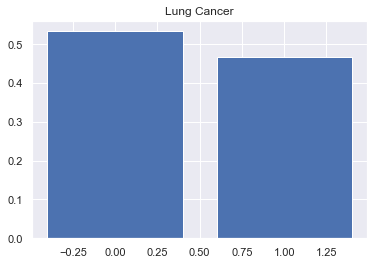

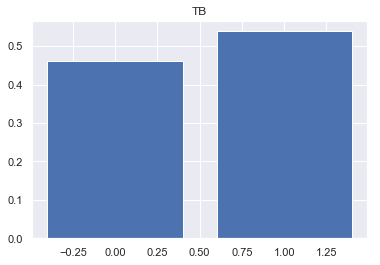

In [19]:
def model():
    works_in_hospital = pflip('hospital', 0.01)
    smokes = pflip('smokes', 0.2)
    
    lung_cancer = (pflip('lung_cancer', 0.01) or 
                   (smokes and pflip('hospital-lung_cancer', 0.01)))
    tb = (pflip('tb', 0.005) or 
          (works_in_hospital and pflip('hospital-tb', 0.01)))
    cold = (pflip('cold', 0.2) or 
            (works_in_hospital and pflip('hospital-cold', 0.25)))
    stomach_flu = pflip('stomach_flu', 0.1)
    other = pflip('other', 0.1)

    cough = ((cold and pflip('cold-cough', 0.5)) or
             (lung_cancer and pflip('lung_cancer-cough', 0.3)) or
             (tb and pflip('tb-cough', 0.7)) or
             (other and pflip('other-cough', 0.01)))

    fever = ((cold and pflip('cold-fever', 0.3)) or
             (stomach_flu and pflip('stomach_flu-fever', 0.5)) or
             (tb and pflip('tb-fever', 0.2)) or
             (other and pflip('other-fever', 0.01)))

    chest_pain = ((lung_cancer and pflip('lung_cancer-chest_pain', 0.4)) or
                  (tb and pflip('tb-chest_pain', 0.5)) or
                  (other and pflip('other-chest_pain', 0.01)))

    shortness_of_breath = ((lung_cancer and pflip('lung_cancer-breath', 0.4)) or
                           (tb and pflip('tb-breath', 0.5)) or
                           (other and pflip('other-breath', 0.01)))


    condition('symptoms', cough and chest_pain and shortness_of_breath)
    return lung_cancer, tb


d_cancer = Infer(
    lambda: model()[0], 
    posterior_method='enumerate', 
    posterior_kwargs={'method': 'DFS'}, 
    num_samples=1000
)
d_tb = Infer(
    lambda: model()[1], 
    posterior_method='enumerate', 
    posterior_kwargs={'method': 'DFS'}, 
    num_samples=1000
)

viz(d_cancer, title='Lung Cancer')
viz(d_tb, title='TB')


Under this model, a patient with coughing, chest pain and shortness of breath is likely to have either lung cancer or TB.  Modify the above code to see how these conditional inferences shift if you also know that the patient smokes or works in a hospital (where they could be exposed to various infections, including many worse infections than the typical person encounters).  More generally, the causal structure of knowledge representation in a probabilistic program allows us to model intuitive theories that can grow in complexity continually over a lifetime, adding new knowledge without bound.


# Example: Inverse intuitive physics

TODO: physics sim


<!--

```
# makes a floor with evenly spaced buckets
def bins(xmin, xmax, width):
    if (xmax < xmin + width):  # floor
        return {'shape': 'rect', 'static': true, 'dims': [400, 10], 'x': 175, 'y': 500}
    return [{'shape': 'rect', 'static': true, dims: [1, 10], x: xmin, y: 490}] \
            .concat(bins(xmin + width, xmax, width))   # bins

# add two fixed circles
world = [
    {shape: 'circle', static: true, dims: [60], x: 60, y: 200},
    {shape: 'circle', static: true, dims: [30], x: 300, y: 300}
].concat(bins(-1000, 1000, 25))

randomBlock = function () {
  return {shape: 'circle', static: false, dims: [10], x: uniform(0, worldWidth), y: 0}
}

```


```
# makes a floor with evenly spaced buckets
def bins(xmin, xmax, width):
    if (xmax < xmin + width):  # floor
        return {'shape': 'rect', 'static': true, 'dims': [400, 10], 'x': 175, 'y': 500}
    return [{'shape': 'rect', 'static': true, dims: [1, 10], x: xmin, y: 490}] \
            .concat(bins(xmin + width, xmax, width))   # bins

# add two fixed circles
world = [
    {shape: 'circle', static: true, dims: [60], x: 60, y: 200},
    {shape: 'circle', static: true, dims: [30], x: 300, y: 300}
].concat(bins(-1000, 1000, 25))

randomBlock = function () {
  return {shape: 'circle', static: false, dims: [10], x: uniform(0, worldWidth), y: 0}
}

getBallX = function(world) {
  ball = filter(function(obj) { return !obj.static }, world)[0];
  return ball.x;
}

observedX = 160;

model = function() {
  initState = world.concat([randomBlock()])
  initX = getBallX(initState);
  finalState = physics.run(1000, initState);
  finalX = getBallX(finalState);
  observe(Gaussian({mu: finalX, sigma: 10}), observedX)
  return {initX: initX}
}

initialXDist = Infer(
  {method: 'MCMC',
   samples: 100,
   lag: 10,
   callbacks: [editor.MCMCProgress()]
  },
  model);

viz.density(initialXDist, {bounds: [0,350]})
```
-->